# IBM AI Enterprise Workflow Capstone Project Part I

### 1) Assimilate the business scenario and articulate testable hypotheses

###### Business Scenario: 

AAVAIL's management wants to explore different ways of revenue generation than the initial subscription-based model. They carried out an experiement using "à la carte" approach. During the experiement, they've been collecting transaction-level purchase data during a couple of years across 38 countries. 

However, the reveue prediction of this new model is time consuming and the management team expects using data science to build accurate models to predict monthly revenue, as well as revenue from a specific country. 

The mangement team assured that well-projected numbers will help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company.

###### Business metrics:

- % of improvement of accuracy in budget projections in comparison to those predicted by the management team

- Amount of time saved during revenue prediction using ML models

###### My Null Hypothesis: 
- The prediction using ML models can not be more accurate than the predictions performed by the management team

- The implementation of ML models doesn't save time during revenue prediction

### 2)  State the ideal data to address the business opportunity and clarify the rationale for needing specific data.

The ideal data would be a set of clean data which contains all those features that the management team considered when projecting revenue using their method, within which should be country as feature and revenue as target variable. The set is based on the features selected by business experts and can be directly used to build a supervised learning model. 


### 3) Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

See data_ingestion.py or get_data()

In [1]:
import re, io
import glob
import os, json
import pandas as pd
import numpy as np
from datetime import date

import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path="./../data/cs-train/"
all_files=glob.glob(os.path.join(path,"*.json"))
df=pd.concat((pd.read_json(f) for f in all_files))
df.head()

,country,customer_id,invoice,total_price,StreamID,TimesViewed,year,month,day,stream_id,times_viewed,price
0,United Kingdom,15581.0,493463,2.95,20895,1.0,2018,1,1,NaN,NaN,NaN
1,United Kingdom,15581.0,493463,1.25,20866,1.0,2018,1,1,NaN,NaN,NaN
2,United Kingdom,15581.0,493463,0.85,85198,12.0,2018,1,1,NaN,NaN,NaN
3,United Kingdom,15581.0,493463,2.95,20897,1.0,2018,1,1,NaN,NaN,NaN
4,United Kingdom,15581.0,493463,2.95,20898,1.0,2018,1,1,NaN,NaN,NaN


The first challenge is to concatenate all the jsons in a single dataframe. However, we got warning about the non-alignment of concatenation axis, which means inconsistents column names within different json files.

In [ ]:
df.columns 

In [ ]:
rename_dictionary={
    "StreamID":"stream_id",
    "TimesViewed":"times_viewed",
    "total_price":"price"
}
df=pd.concat((pd.read_json(f).rename(columns=rename_dictionary) for f in all_files))
df.head()

We merge the column year_month_day in an only column

In [ ]:
df["date"]=df.year.astype(str)+"-"+df.month.astype(str).str.zfill(2)+"-"+df.day.astype(str).str.zfill(2)
df.head()

In [ ]:
def get_data(path):
    all_files=glob.glob(os.path.join(path,"*.json"))
    rename_dictionary={
        "StreamID":"stream_id",
        "TimesViewed":"times_viewed",
        "total_price":"price"}
    df=pd.concat((pd.read_json(f).rename(columns=rename_dictionary) for f in all_files))
    df["date"]=df.year.astype(str)+"-"+df.month.astype(str).str.zfill(2)+"-"+df.day.astype(str).str.zfill(2)
    df.invoice=df.invoice.astype(str).str.replace("[a-zA-Z]","")
    return df.drop_duplicates()


### 4) Investigate the relationship between the relevant data, the target and the business metric.

#### 4.1 Know about duplications and missing data
- Drop duplicate data
- Explore missing values

#### 4.2 Relationship between different columns
- Relationship between customer_id, stream_id, times_viewed and price
- Explore the behaviour of different countries

In [ ]:
print("Before drop duplicates")
print(collections.Counter(df.duplicated()))
df=df.drop_duplicates()
print("After dropped duplicates")
print(collections.Counter(df.duplicated()))

In [ ]:
print("Drop invoice ids with letters")
df.invoice=df.invoice.astype(str).str.replace("[a-zA-Z]","")

In [ ]:
print("Explore missing values")
df.isnull().sum()

In [ ]:
df[df.customer_id.isna()]

We must decide what to do with the null values,  firstly the amount of missing values in customer_id is meaningful, and since our target variable is price aggreagate by country and by month, we could keep these rows.

In [ ]:
print(df.groupby(["customer_id"]).agg({"invoice": pd.Series.nunique}).head())
df.groupby(["invoice"]).agg({"stream_id":pd.Series.nunique}).head()

A single customer have different invoices and a invoice have different stream_ids which reference to the contents the customer have seen.

In [ ]:
df_g=pd.DataFrame(df.groupby(["country"]).price.sum()).reset_index().sort_values(by="price",ascending=False)
sns.catplot(data=df_g[:15], y="country",x="price",kind="bar")
sorted_countries=df_g.country.values
plt.title("Top 15 countries with highest total price")
plt.show()

We observe high differences between the total price which could be influenced by the number of customers, so we normalize the prices to price per customer.

In [ ]:
df_g=pd.DataFrame(df.groupby(["country"]).agg({
    "price":"sum",
    "customer_id":pd.Series.nunique
})).reset_index()
df_g["prices_customer"]=np.divide(df_g.price,df_g.customer_id,out=np.zeros_like(df_g.price), where=df_g.customer_id!=0)
df_g=df_g.sort_values(by="prices_customer",ascending=False).rename(columns={
    "customer_id":"n_customers"
})
sorted_countries_mean=df_g.country.values
sns.catplot(data=df_g.sort_values(by="prices_customer",ascending=False)[:15], y="country",x="prices_customer",kind="bar")
plt.title("Top 15 countries with highest prices per customer")
print(df_g[:15])
plt.show()

There were two countries with non customers which was no considered for price per customer calculation

In [ ]:
p_uk=df_g[df_g.country=="United Kingdom"].price/df_g.price.sum()

p_uk

In [ ]:
df_g[df_g.n_customers==0].country

In [ ]:
plt.figure(figsize=(20,10))
g=sns.relplot(
    data=df_g, 
    x="n_customers",y="prices_customer")
plt.xlim((0,40))
plt.ylim(0,700)

In [ ]:
df_g.loc[df_g.prices_customer>800]

EIRE, Singapore and Norway has high prices per customer but with very few customers. If we remember that there were missing values in customer_ids, we can expect to find these customer_ids with these countries.

In [ ]:
df[df.customer_id.isna()].country.value_counts()

We also discovered here that there where data with country Unspecified, we must filter these data when predicting revenue for countries.

An other way to scale the total price is with the number of invoices, in this case, we have the advantage of that we wouldn't need to deal with missing data

In [ ]:
df_g=pd.DataFrame(df.groupby(["country"]).agg({
    "price":"sum",
    "invoice":pd.Series.nunique
})).reset_index()
df_g["prices_invoice"]=np.divide(df_g.price,df_g.invoice,out=np.zeros_like(df_g.price), where=df_g.invoice!=0)
df_g=df_g.sort_values(by="prices_invoice",ascending=False).rename(columns={
    "invoice":"n_invoice"
})
sorted_countries_mean=df_g.country.values
sns.catplot(data=df_g.sort_values(by="prices_invoice",ascending=False)[:15], y="country",x="prices_invoice",kind="bar")
plt.title("Top 15 countries with highest prices per invoice")
print(df_g[:15])
plt.show()

In [ ]:
df_g=pd.DataFrame(df.groupby(["country","year"]).agg({
    "price":"mean"
})).reset_index().sort_values(by="price",ascending=False)
plt.figure(figsize=(14,6))
df_g=df_g[df_g.country.isin(sorted_countries[:15])]
sns.catplot(data=df_g, x="price",y="country",hue="year", kind="bar")

In [ ]:
df_g=pd.DataFrame(df.groupby(["country","year"]).agg({
    "times_viewed":"mean"
})).reset_index().sort_values(by="times_viewed",ascending=False)
plt.figure(figsize=(14,6))
df_g=df_g[df_g.country.isin(sorted_countries[:15])]
sns.catplot(data=df_g, x="times_viewed",y="country",hue="year", kind="bar")

In [ ]:
df.date=pd.to_datetime(df.date)
df_g=df.groupby(["year","month","country"]).price.sum().reset_index()
df_g["year_month"]=df_g.year.astype(str)+"-"+df_g.month.astype(str).str.zfill(2)

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x="year_month",y="price",data=df_g[df_g.country.isin(sorted_countries[:10])],hue="country")

In [ ]:
df_g=df.groupby(["date","country"]).price.sum().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(x="date",y="price",data=df_g[df_g.country.isin(sorted_countries[:10])],hue="country")

In [ ]:
from statsmodels.tsa.stattools import adfuller
df_g=df.groupby(["date"]).price.sum().reset_index()
X = df_g.price.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

#### 5) Articulate your findings using a deliverable with visualizations.
- We discovered that the United Kindong is obviously the main market of the company,around 90% of the whole revenue

In [ ]:
sorted_countries[:15]

- These are the top 15 countries with highest revenue ordered from higher to lower
- We find the highest revenue per costumber in EIRE, Singapore and Norway, and the highest revenue per invoice in HongKong, Singapore and Norway. 
- We also understood that the majority of the countries has their price per customer under 1000, except EIRE, Singapore, Norway, RSA and Malta. 
- The AD stationarity test turns that the daily acumulated price is stationary.
- The daily price plot per country suggested that the data from UK is stationary.


# PART II: Time Series Analysis

##### 1) State the different modeling approaches that you will compare to address the business opportunity.
I will compapre autoregressive models  and Facebook prophet
##### 2) Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
##### 3) Re-train your model on all of the data using the selected approach and prepare it for deployment.
##### 4) Articulate your findings in a summary report.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from data_ingestion import *
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AR
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

In [9]:
path="./../data/cs-train/"
df=get_data(path)


/Users/weiyi/PycharmProjects/ai-workflow-capstone/notebooks/data_ingestion.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df.invoice=df.invoice.astype(str).str.replace("[a-zA-Z]","")


(495, 2)
(611, 2)


<AxesSubplot:xlabel='date'>

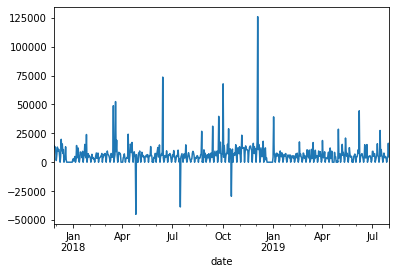

In [10]:
df_daily=df.groupby(["date"]).price.sum().reset_index()
df_daily["date"]=df_daily.date.astype(np.datetime64)
df_daily.index=df_daily.date
print(df_daily.shape)
df_daily=df_daily.asfreq(freq="1D",fill_value=1)
print(df_daily.shape)
df_daily=df_daily[["price"]]
df_daily.price.plot()

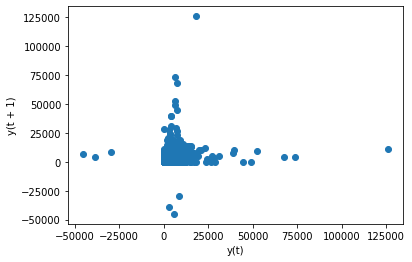

In [11]:
lag_plot(df_daily)
plt.show()

In [12]:
result=pd.concat([df.price.shift(1),df.price],axis=1)
result.columns=["t-1","t+1"]
result=result.corr()
print("Correlation for lag =1")
print(result)

Correlation for lag =1
          t-1       t+1
t-1  1.000000  0.087422
t+1  0.087422  1.000000


Text(0.5, 1.0, 'Correlation lag plot')

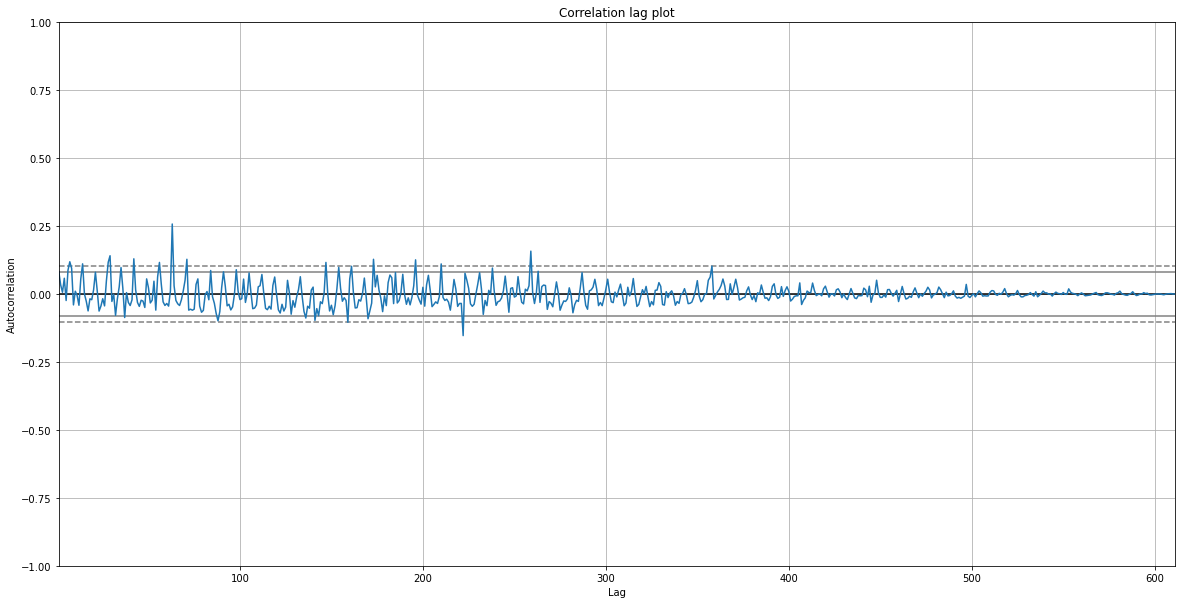

In [13]:
plt.figure(figsize=(20,10))
autocorrelation_plot(df_daily)
plt.title("Correlation lag plot")

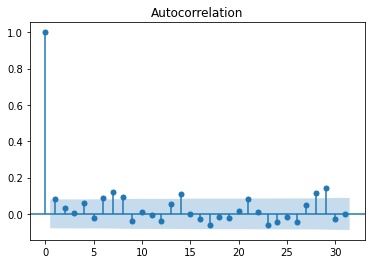

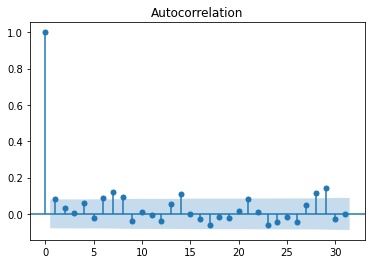

In [14]:
plot_acf(df_daily.price,lags=31)

predicted=6234.752707, expected=5013.510000
predicted=4838.529381, expected=3616.490000
predicted=3129.826837, expected=1.000000
predicted=6308.141188, expected=3129.530000
predicted=7877.762442, expected=4366.650000
predicted=5657.096772, expected=16369.710000
predicted=5651.008442, expected=4927.450000
Test RMSE: 4636.647


/Users/weiyi/anaconda3/envs/aicourse/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


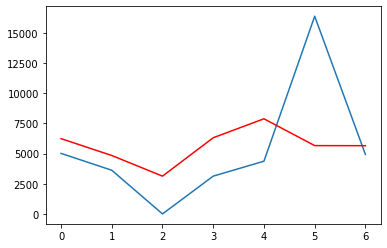

In [15]:
### Model AUTOREG  LAGS=16
X=df_daily.values
train, test = X[1:len(X)-7], X[len(X)-7:]
model=AutoReg(train, lags=16)
res=model.fit()
predictions = res.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

/Users/weiyi/anaconda3/envs/aicourse/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/weiyi/anaconda3/envs/aicourse/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 4951.396


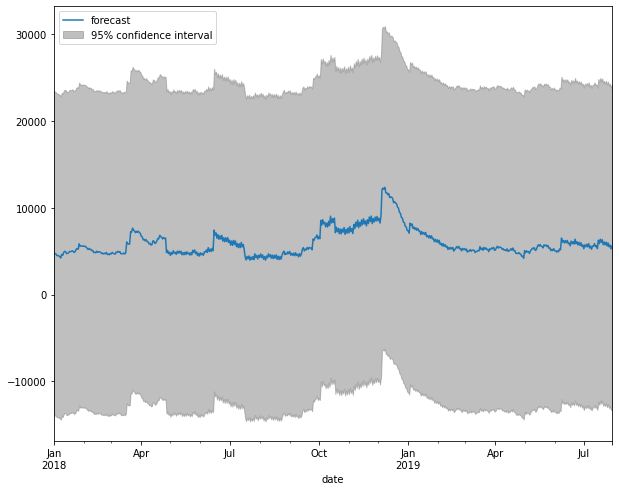

In [16]:
### Model AR
X=df_daily.values
#train, test = df_daily[1:len(X)-7], X[len(X)-7:]
model=ARIMA(df_daily,order=(2,0,2),trend="n")
res=model.fit()
fig, ax = plt.subplots(figsize=(10,8))
fig = plot_predict(res, start='2018-01-01', end='2019-07-30', ax=ax)
legend = ax.legend(loc='upper left')
predictions = res.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

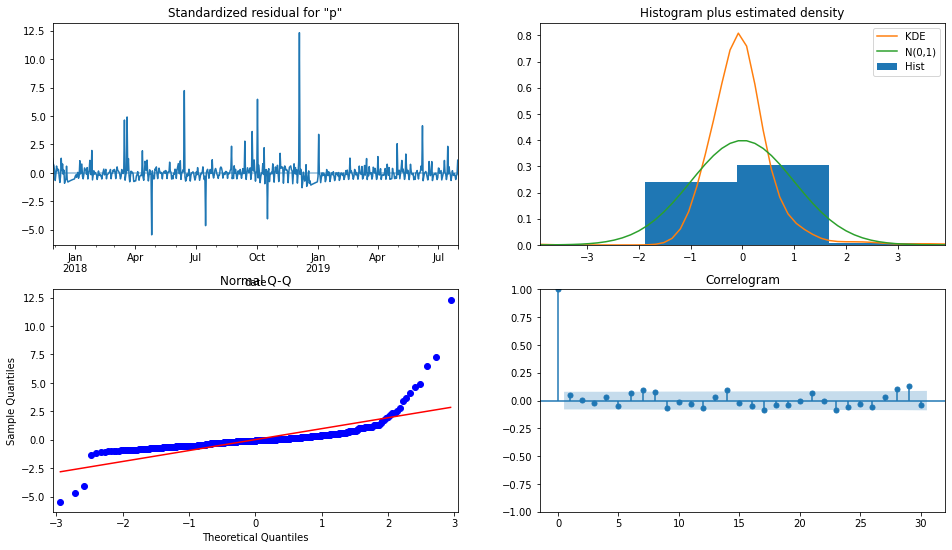

In [17]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig,lags=30)

/Users/weiyi/anaconda3/envs/aicourse/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/weiyi/anaconda3/envs/aicourse/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/weiyi/anaconda3/envs/aicourse/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


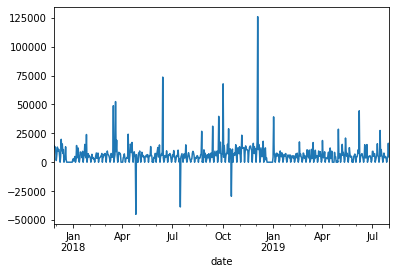

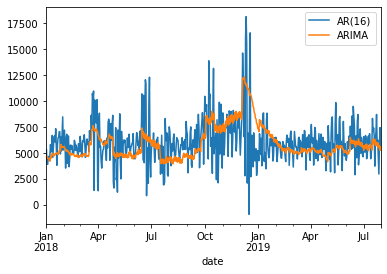

In [18]:

ar_model=AutoReg(df_daily, lags=16)
res_ar=ar_model.fit()
arima_model=ARIMA(df_daily,order=(2,0,2),trend="n")
res_arima=arima_model.fit()
predictions = pd.DataFrame({"AR(16)": res_ar.predict(start='2018-01-01', end='2019-07-30'),
                            "ARIMA": res_arima.predict(start='2018-01-01', end='2019-07-30')}
                          )
ax=df_daily.price.plot()
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)



In [19]:
def prophet_predict(data, period, changepoint_scale=0.5):

    df = pd.DataFrame()
    df['ds'] = data.index
    df['y'] = data.price.values
    m = Prophet(changepoint_prior_scale=changepoint_scale)
    m_fit = m.fit(df)
    future = m.make_future_dataframe(periods = period)
    forecast = m.predict(future)
    forecast = forecast.round(0)
    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)

    return forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


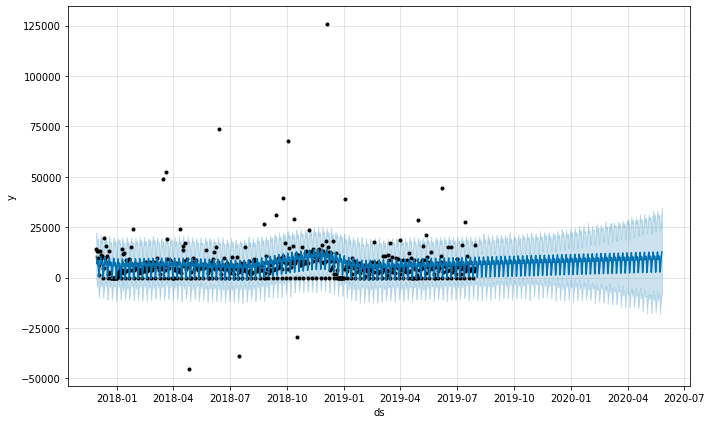

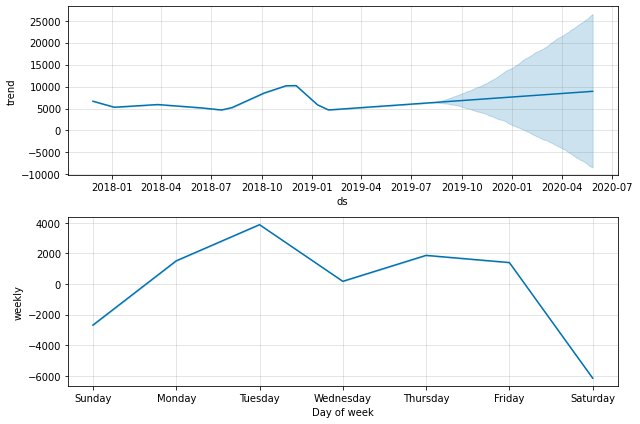

In [21]:
forecast= prophet_predict(df_daily,300)